<a href="https://colab.research.google.com/github/yoneda-kg/sparce/blob/main/ISTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
m = 150 # 観測ベクトル次元
n = 300 # 元信号ベクトル次元
sigma = 0.05 # 雑音の標準偏差
mbs   = 20 # ミニバッチサイズ
p     = 1.0 # 元信号の非ゼロ元の生起確率
A = torch.normal(torch.zeros(m, n), std = 1.0) # 観測行列
max_itr = 20 # ISTAの反復回数
adam_lr = 0.0001 # Adamの学習率

In [ ]:
def gen_minibatch():
    seq = torch.normal(torch.zeros(mbs, n), 1.0) # ガウス乱数ベクトルの生成
    support = torch.bernoulli(p * torch.ones(mbs, n)) # 非ゼロサポートの生成
    return seq * support # 要素ごとの積(アダマール積)になることに注意

In [ ]:
class ISTA(nn.Module):
    def __init__(self, max_itr):
        super(ISTA, self).__init__()
        self.beta = nn.Parameter(0.001*torch.ones(max_itr)) # 学習可能ステップサイズパラメータ
        self.lam  = nn.Parameter(0.1*torch.ones(max_itr)) # 学習可能縮小パラメータ
    def shrinkage(self, x, lam): # 縮小関数 (ソフトしきい値関数)
        return (x-lam)*(x-lam > 0).float() + (x + lam)*(x+lam < 0).float()
    def forward(self, num_itr):
        s = torch.zeros(mbs, n) # 初期探索点
        for i in range(num_itr):
            r = s + self.beta[i] * (y - s @ A.t()) @ A # @は普通の行列・ベクトル積
            s = self.shrinkage(r, self.lam[i])
        return s

In [ ]:
Mse=[]
model = ISTA(max_itr)
opt   = optim.Adam(model.parameters(), lr=adam_lr)
loss_func = nn.MSELoss()
for param in model.named_parameters():
    print(param)
for gen in range(max_itr):
    for i in range(50):
        x = gen_minibatch() # 元信号の生成
        w = torch.normal(torch.zeros(mbs, m), sigma)
        y = torch.mm(x, A.t()) + w # 観測信号の生成
        opt.zero_grad()
        x_hat = model(gen + 1)
        loss  = loss_func(x_hat, x)
        loss.backward()
        opt.step()
    Mse.append(loss.item())
    print(gen, loss.item())



('beta', Parameter containing:
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010], requires_grad=True))
('lam', Parameter containing:
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000], requires_grad=True))
0 0.6689596176147461
1 0.5787485241889954
2 0.5667346119880676
3 0.5300665497779846
4 0.5201404690742493
5 0.5124293565750122
6 0.5471960306167603
7 0.5246923565864563
8 0.5163708329200745
9 0.5043233036994934
10 0.5389581918716431
11 0.5308645963668823
12 0.5311896800994873
13 0.551690936088562
14 0.5572980642318726
15 0.49308478832244873
16 0.5081564784049988
17 0.5266031622886658
18 0.5298922657966614
19 0.5298506021499634


In [ ]:
print(Mse)

[0.08227401971817017, 0.027452293783426285, 0.030274126678705215, 0.01841992884874344, 0.008538867346942425, 0.009336501359939575, 0.005131416488438845, 0.016180533915758133, 0.016274916008114815, 0.015556933358311653, 0.006955750752240419, 0.0014024315169081092, 0.007638539653271437, 0.001064686686731875, 0.01632850058376789, 0.0009858936537057161, 0.0035295463167130947, 0.0018303784308955073, 0.0011427535209804773, 0.0012254822067916393]


In [ ]:
print(len(Mse))

20


In [ ]:
mbs = 1
with torch.no_grad():
    x = gen_minibatch()
    w = torch.normal(torch.zeros(m), sigma)
    y = torch.mm(x, A.t()) + w
    s = model(max_itr)

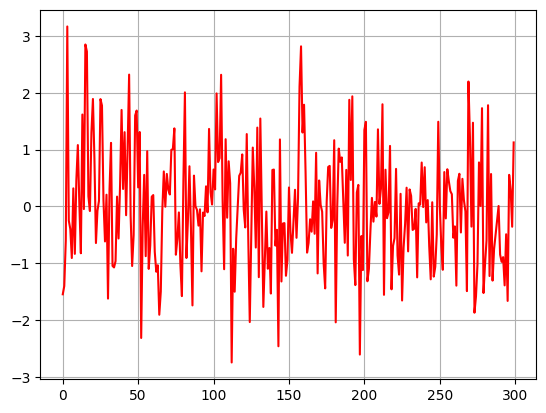

In [ ]:
plt.grid()
plt.plot(range(n), x.view(n).cpu().numpy(), color="red")

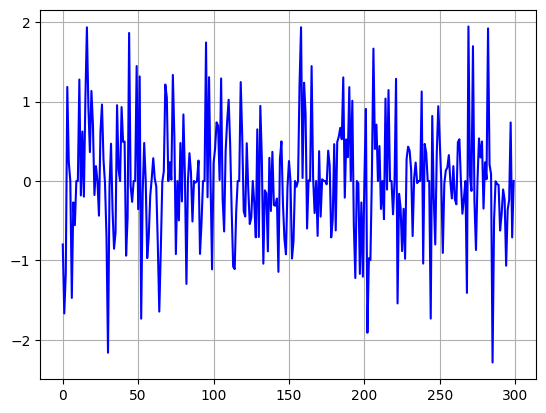

In [ ]:
plt.grid()
plt.plot(range(n), s.view(n).detach().numpy(), color="blue")

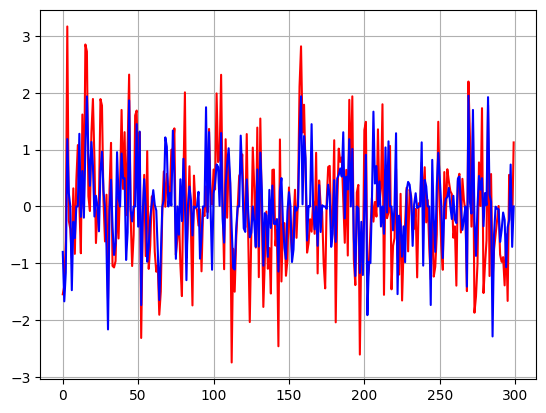

In [ ]:
plt.grid()
plt.plot(range(n), x.view(n).detach().numpy(), color="red")
plt.plot(range(n), s.view(n).detach().numpy(), color="blue")

In [ ]:
print('model.beta = ', model.beta)
print('model.lam = ', model.lam)

model.beta =  Parameter containing:
tensor([ 4.8262e-03,  3.5379e-03,  2.5637e-02,  5.7203e-03, -2.6350e-04,
         2.3801e-03,  4.1862e-03,  5.4987e-04,  1.8342e-03,  1.8060e-03,
         7.1203e-04,  1.9202e-03,  1.5156e-03,  1.4826e-03,  1.8767e-02,
        -5.7375e-04,  1.3730e-05,  3.5637e-04,  1.2137e-03,  9.9283e-04],
       requires_grad=True)
model.lam =  Parameter containing:
tensor([0.0612, 0.0768, 0.0741, 0.0724, 0.0683, 0.0782, 0.0687, 0.0625, 0.0734,
        0.0552, 0.0488, 0.0519, 0.0583, 0.0687, 0.0471, 0.0529, 0.0529, 0.0600,
        0.0680, 0.0808], requires_grad=True)


MSE

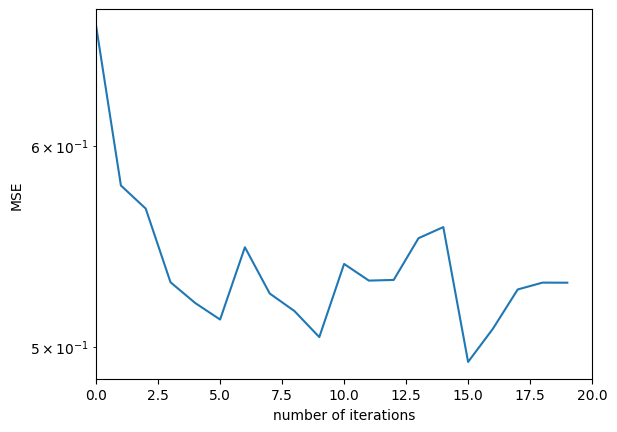

In [ ]:
x=list(range(20))
plt.plot(x,Mse)
plt.yscale('log')
plt.xlim(0, 20)
plt.ylabel("MSE")
plt.xlabel("number of iterations")
plt.show()